In [0]:
import os
!rm -rf *
!rm -rf .kaggle/
!git clone https://github.com/bkahn-github/data-science-bowl.git
!pip install -r data-science-bowl/requirements.txt
!mkdir ~/.kaggle
f = open(".kaggle/kaggle.json", "w")
f.write('{"username":"bkkaggle","key":"bf4e62680116284087ace0484990f87a"}')
f.close()
!kaggle competitions download -c data-science-bowl-2018
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_train.zip -d ~/.kaggle/competitions/data-science-bowl-2018/train
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_test.zip -d ~/.kaggle/competitions/data-science-bowl-2018/test
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_train_labels.csv.zip -d ~/.kaggle/competitions/data-science-bowl-2018/labels
os.chdir('data-science-bowl/pytorchUnet')

!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

In [0]:
os.chdir('../../')
!rm -rf data-science-bowl/
%reload_ext autoreload
%autoreload 0
!git clone https://github.com/bkahn-github/data-science-bowl.git
os.chdir('data-science-bowl/pytorchUnet')

In [0]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch.backends import cudnn
import torchvision.transforms as transforms

from tqdm import tqdm, tqdm_notebook

np.random.seed(123)
torch.manual_seed(123)
torch.cuda.manual_seed(123)
cudnn.benchmark = True

%matplotlib inline

from load_data import load_data
from metrics import dice_loss, iou
from model import UNet
from process_data import threshold_preds, predict, encode, upsample
from visualize import show_val, show_test
from submit import submit

In [5]:
train, val, x_test_sizes, train_dataset, val_dataset, test_dataset, train_dataloader, val_dataloader, test_dataloader = load_data(batch_size=16)

100%|██████████| 65/65 [00:00<00:00, 150.14it/s]


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2)
        else:
            self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2), diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
      x1 = self.inc(x)
      x2 = self.down1(x1)
      x3 = self.down2(x2)
      x4 = self.down3(x3)
      x5 = self.down4(x4)
      x = self.up1(x5, x4)
      x = self.up2(x, x3)
      x = self.up3(x, x2)
      x = self.up4(x, x1)
      x = self.outc(x)
      x = F.sigmoid(x)
      return x

In [0]:
model = UNet(3, 1).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

for epoch in range(10):
  train_ious = []
  val_ious = []

  for x_train, y_train in tqdm(train_dataloader):

    x_train = Variable(x_train).cuda()
    y_train = Variable(y_train).cuda()

    optimizer.zero_grad()

    outputs = model(x_train)

    loss = dice_loss(outputs, y_train)
    train_iou, _ = iou((outputs.cpu().data.squeeze(0).numpy() > 0.5), y_train.cpu().data.numpy())
    train_ious.append(train_iou)

    loss.backward()
    optimizer.step()

  for x_val, y_val in tqdm(val_dataloader):
    x_val = Variable(x_val).cuda()
    y_val = Variable(y_val).cuda()

    optimizer.zero_grad()

    o = model(x_val)

    val_loss = dice_loss(o, y_val)
    val_iou, _ = iou((o.cpu().data.squeeze(0).numpy() > 0.5), y_val.cpu().data.numpy())
    val_ious.append(val_iou)

  print('\n')
  print(f'Epoch: {epoch + 1} Training IOU: {np.asarray(train_ious).mean()} Val IOU: {np.asarray(val_ious).mean()} Training Loss: {round(loss.data[0], 4)} Val Loss: {round(val_loss.data[0], 4)}', end='\n')

0.7


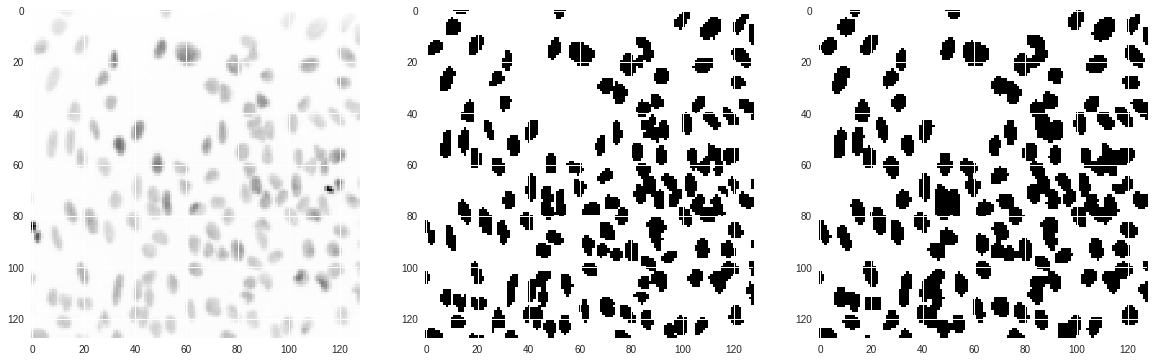

In [24]:
show_val(1, model, iou, val_dataset)

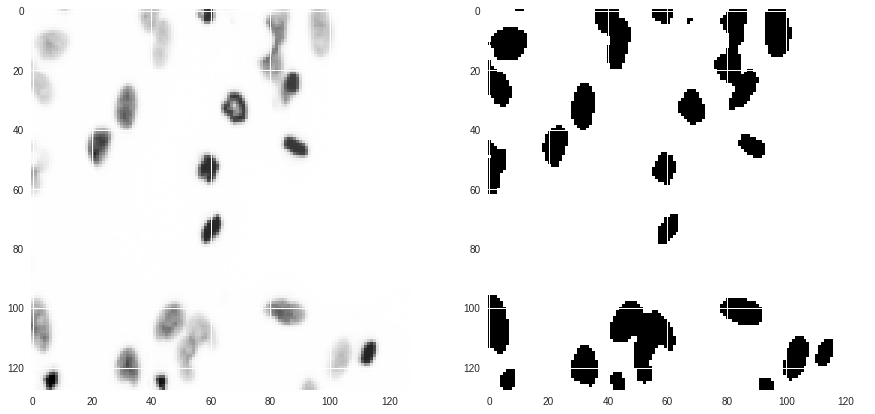

In [27]:
show_test(1, model, test_dataset)

In [28]:
preds = predict(model, test_dataset, test_dataloader, optimizer)

65it [00:01, 45.50it/s]


In [0]:
preds = threshold_preds(preds)

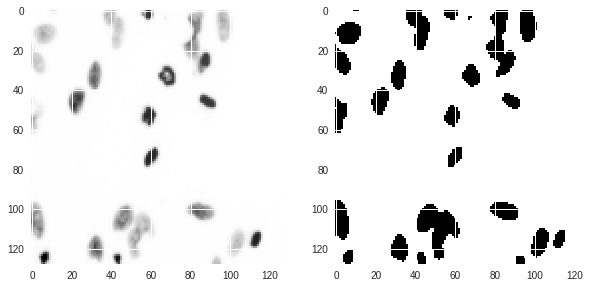

In [30]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(test_dataset[1][0].numpy().reshape(128, 128)*0.5+0.5)

plt.subplot(1, 2, 2)
plt.imshow(preds[1])

In [0]:
from skimage.transform import resize
from skimage.morphology import label

def upsample(preds, x_test_sizes):
    preds_test_upsampled = []
    for i in range(len(preds)):
        preds_test_upsampled.append(resize(np.squeeze(preds[i]), x_test_sizes[i], mode='constant', preserve_range=True).astype(np.uint8))

    return preds_test_upsampled

preds_upsampled = upsample(preds, x_test_sizes)

In [0]:
test_path = '../../.kaggle/competitions/data-science-bowl-2018/test/'
test_ids = next(os.walk(test_path))[1]

rles, new_test_ids = encode(preds_upsampled, test_ids)

In [0]:
submit(new_test_ids, rles)

In [0]:
pd.read_csv('./submission.csv')

In [0]:
from google.colab import files

files.download('submission.csv')